# Setup

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.char_tokenizer import CharTokenizer

In [3]:
tf.config.experimental.get_memory_info("GPU:0")

{'current': 0, 'peak': 0}

In [2]:
config = json.load(open("config.json"))

# Downloading and preprocessing data

In [3]:
from utils.data_loader import download_abo, preprocess_data

In [4]:
download_abo(config["data"]["path"])

100%|██████████| 83.4M/83.4M [00:04<00:00, 21.4MB/s]


100%|██████████| 3.03G/3.03G [02:18<00:00, 23.5MB/s] 


Extracting listings...
Extracting images...
Done


In [5]:
preprocess_data(config["data"]["path"], alt_augment=False, random_deletion=False)

Loading images...
Loading texts...
Importing listings CSV...
Creating ground truth...
Merging images and texts...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Done


In [6]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data = data[['description', 'path', 'product_type', 'label']]
data

,description,path,product_type,label
0,dried goji berriesb07s1cpsm2amazonbasics mini ...,ea/ea19d1da.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07txdzls7amazon brand - solimo de...,0d/0d7304e9.jpg,SHOES,0
2,back coverb0853x5d4namazon brand - solimo desi...,6e/6e80edf5.jpg,CELLULAR_PHONE_CASE,1
3,ear defenders bluetooth muffs noise cancelling...,ef/ef3214b3.jpg,BISS,1
4,ukb07tg4l3md现代乡村风格 farmhouse 照片,31/31886e15.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
156974,mobile coverb07tf1dn5yamazon brand - solimo de...,1f/1f0be221.jpg,CELLULAR_PHONE_CASE,1
156975,cellphonecoverb08563y4shamazon brand - solimo ...,e5/e5507926.jpg,CELLULAR_PHONE_CASE,1
156976,frb07b4w5t8yamazonbasics abs 3d printer filame...,d7/d70cd9f6.jpg,SHOES,0
156977,sofasb085fmnl5y[amazon collection] amazon coll...,d2/d2fbefe0.jpg,WALLET,0


In [ ]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [ ]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(157056, 1014)

## Create embedding weights

In [ ]:
weights = tk.create_embedding_weights()
weights.shape

(3202, 3201)

# Image processing

## Load image model

In [ ]:
from utils import img_models

In [ ]:
img_model = img_models.load(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [11]:
img = img_models.create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"))

Found 157215 validated image filenames.


2023-05-23 13:41:52.528294: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


In [12]:
img.shape

(157215, 576)

# Save embeddings

In [5]:
save_path = os.path.join(config["data"]["path"], "embeddings")

In [14]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [6]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

FileNotFoundError: [Errno 2] No such file or directory: './datasets/abo/embeddings/data.csv'

In [ ]:
img = np.load(f"{save_path}/img.npy")
img.shape

(157056, 576)

In [ ]:
text = np.load(f"{save_path}/text.npy")
text.shape

(157056, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [ ]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > 1]

In [ ]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=0.1, random_state=42)

In [ ]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [7]:
from models.char_cnn_zhang import CharCNNZhang

In [8]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

NameError: name 'tk' is not defined

In [ ]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

In [ ]:
from models.mnn_em import MNNEM
from utils.eval import create_metrics

In [ ]:
mnn_em = MNNEM(
    img_input_size=img_model.layers[-1].output_shape[1],
    txt_input_size=config["data"]["input_size"],
    txt_weights=weights,
    char_cnn_config=char_cnn_config,
    fc_layers=config["mnn_em"]["fc_layers"],
    combined_fc_layers=config["mnn_em"]["combined_fc_layers"],
    learning_rate=config["mnn_em"]["training"]["learning_rate"],
    metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [ ]:
mnn_em.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Character_Level_CNN (Functiona  (None, 2048)        29295234    ['Text_Input[0][0]']             
 l)                                                                                               
                                                                                                  
 Image_FC_1 (Dense)             (None, 1024)         590848      ['Image_Input[0][0]']        

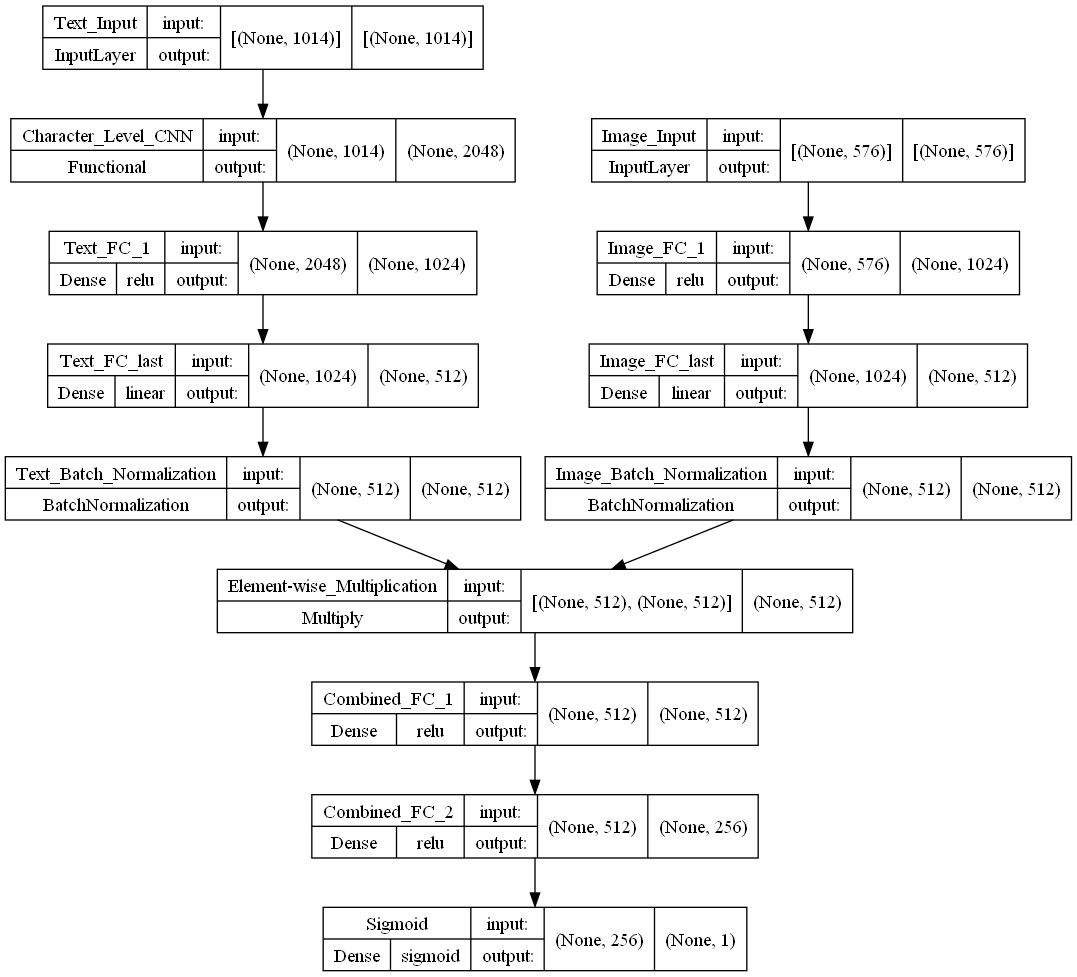

In [26]:
tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

# Callbacks

In [30]:
from utils.eval import create_callbacks

In [31]:
model_name = config["mnn_em"]["name"]
optimizer_name = config["mnn_em"]["training"]["optimizer"]
learning_rate = config["mnn_em"]["training"]["learning_rate"]

In [32]:
callbacks = create_callbacks(
    callbacks_list=config["mnn_em"]["training"]["callbacks"],
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    )

# Training

In [33]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


Epoch 1/10
7952/7956 [============================>.] - ETA: 0s - loss: 0.9771 - recall: 0.9375 - precision: 0.8758 - binary_accuracy: 0.8911 - cosine_similarity: 0.5570

2023-05-23 14:01:35.340799: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 98s 12ms/step - loss: 0.9768 - recall: 0.9375 - precision: 0.8758 - binary_accuracy: 0.8911 - cosine_similarity: 0.5569 - val_loss: 0.2542 - val_recall: 0.9798 - val_precision: 0.9026 - val_binary_accuracy: 0.9304 - val_cosine_similarity: 0.5525
Epoch 2/10
7956/7956 [==============================] - ETA: 0s - loss: 0.1768 - recall: 0.9748 - precision: 0.9366 - binary_accuracy: 0.9492 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 92s 12ms/step - loss: 0.1768 - recall: 0.9748 - precision: 0.9366 - binary_accuracy: 0.9492 - cosine_similarity: 0.5570 - val_loss: 0.1627 - val_recall: 0.9885 - val_precision: 0.9299 - val_binary_accuracy: 0.9525 - val_cosine_similarity: 0.5526
Epoch 3/10
7956/7956 [==============================] - 87s 11ms/step - loss: 0.1387 - recall: 0.9805 - precision: 0.9505 - binary_accuracy: 0.9607 - cosine_similarity: 0.5570 - val_loss: 0.1927 - val_recall: 0.9566 - val_precision: 0.9396 - val_binary_accuracy: 0.9420 - val_cosine_similarity: 0.5526
Epoch 4/10
7952/7956 [============================>.] - ETA: 0s - loss: 0.1129 - recall: 0.9835 - precision: 0.9620 - binary_accuracy: 0.9691 - cosine_similarity: 0.5569

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 93s 12ms/step - loss: 0.1129 - recall: 0.9835 - precision: 0.9620 - binary_accuracy: 0.9691 - cosine_similarity: 0.5570 - val_loss: 0.1440 - val_recall: 0.9831 - val_precision: 0.9436 - val_binary_accuracy: 0.9582 - val_cosine_similarity: 0.5526
Epoch 5/10
7953/7956 [============================>.] - ETA: 0s - loss: 0.0936 - recall: 0.9861 - precision: 0.9700 - binary_accuracy: 0.9753 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 92s 12ms/step - loss: 0.0936 - recall: 0.9861 - precision: 0.9700 - binary_accuracy: 0.9753 - cosine_similarity: 0.5570 - val_loss: 0.1364 - val_recall: 0.9867 - val_precision: 0.9479 - val_binary_accuracy: 0.9627 - val_cosine_similarity: 0.5526
Epoch 6/10
7956/7956 [==============================] - ETA: 0s - loss: 0.0801 - recall: 0.9877 - precision: 0.9749 - binary_accuracy: 0.9790 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 93s 12ms/step - loss: 0.0801 - recall: 0.9877 - precision: 0.9749 - binary_accuracy: 0.9790 - cosine_similarity: 0.5570 - val_loss: 0.1249 - val_recall: 0.9587 - val_precision: 0.9703 - val_binary_accuracy: 0.9610 - val_cosine_similarity: 0.5526
Epoch 7/10
7952/7956 [============================>.] - ETA: 0s - loss: 0.0703 - recall: 0.9885 - precision: 0.9793 - binary_accuracy: 0.9820 - cosine_similarity: 0.5569

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 92s 12ms/step - loss: 0.0703 - recall: 0.9884 - precision: 0.9793 - binary_accuracy: 0.9819 - cosine_similarity: 0.5570 - val_loss: 0.1231 - val_recall: 0.9662 - val_precision: 0.9677 - val_binary_accuracy: 0.9635 - val_cosine_similarity: 0.5526
Epoch 8/10
7955/7956 [============================>.] - ETA: 0s - loss: 0.0629 - recall: 0.9899 - precision: 0.9815 - binary_accuracy: 0.9840 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 93s 12ms/step - loss: 0.0629 - recall: 0.9899 - precision: 0.9815 - binary_accuracy: 0.9840 - cosine_similarity: 0.5570 - val_loss: 0.1138 - val_recall: 0.9795 - val_precision: 0.9604 - val_binary_accuracy: 0.9663 - val_cosine_similarity: 0.5526
Epoch 9/10
7956/7956 [==============================] - 87s 11ms/step - loss: 0.0567 - recall: 0.9911 - precision: 0.9839 - binary_accuracy: 0.9860 - cosine_similarity: 0.5570 - val_loss: 0.1258 - val_recall: 0.9784 - val_precision: 0.9647 - val_binary_accuracy: 0.9683 - val_cosine_similarity: 0.5526
Epoch 10/10
7956/7956 [==============================] - 88s 11ms/step - loss: 0.0525 - recall: 0.9923 - precision: 0.9852 - binary_accuracy: 0.9874 - cosine_similarity: 0.5570 - val_loss: 0.1348 - val_recall: 0.9752 - val_precision: 0.9647 - val_binary_accuracy: 0.9666 - val_cosine_similarity: 0.5525


# Evaluation

## Plot loss and metrics

In [34]:
from utils.eval import plot_metrics

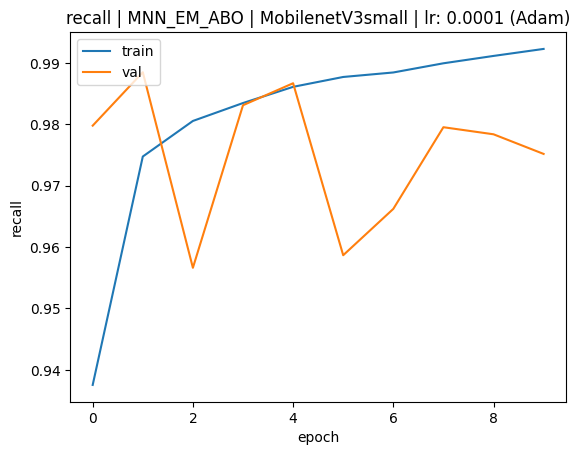

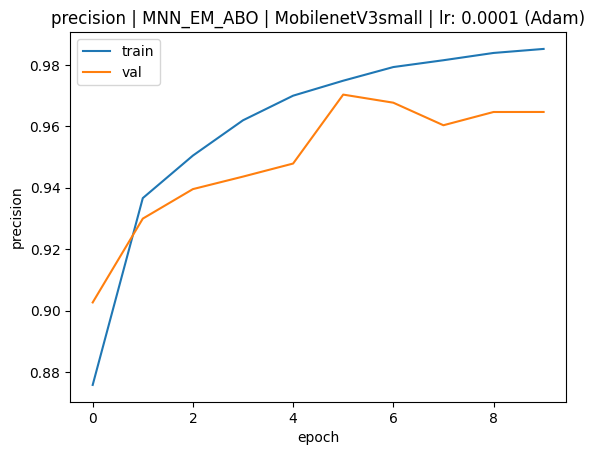

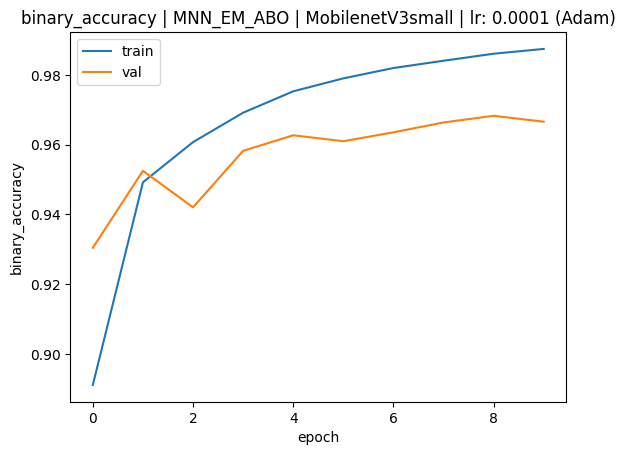

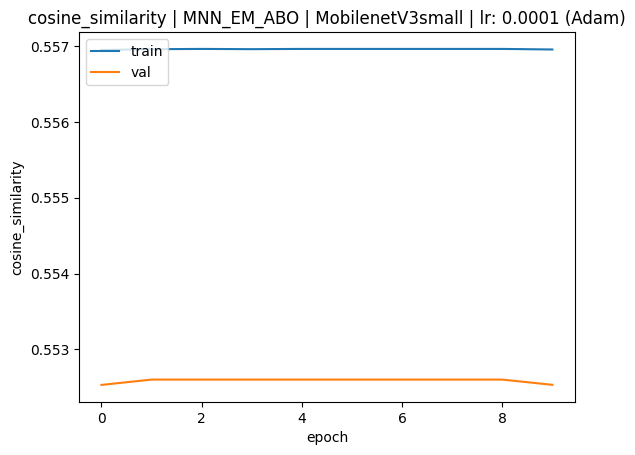

In [35]:
plot_metrics(history.history, config["mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate)

## Evaluate model and save metrics

In [36]:
from utils.eval import evaluate

In [37]:
evaluate(mnn_em.model, img_test, text_test, labels_test, model_name, img_model.name, optimizer_name, learning_rate)

15716/15716 [==============================] - 73s 5ms/step - loss: 0.1348 - recall: 0.9794 - precision: 0.9629 - binary_accuracy: 0.9679 - cosine_similarity: 0.5507
